# 评估

## 3.1 经验误差与过拟合
通常我们把分类错误的样本数站样本总数的比例称为“错误率”（error rate），即如果在m个样本中由a个样本分类错误，则错误率$E=a/m$;相应的$1-a/m$称为“精度”(accuracy)，即“精度=1-错误率”。更一般的我们把学习器的实际预测输出与样本的真实输出之间差异称为“误差”(error),学习器在训练集上的误差称为“训练误差”(training error),或经验误差(empirical error),在新样本上的误差称为"泛化误差"(generalization error).显然我们希望得到泛化误差小的学习器，然而我们事先并不知道新样本是什么样，实际中能做的是努力使得经验误差最小化。在很多情况下，我们可以学得一个经验误差狠下、在训练集上表现很好的学习器，例如甚至对多有训练样本都分类正确，即分类错误为0，分类精度为$100\%$,但这是不是我们想要的学习器呢？遗憾的是，这样的学习器在多数情况下都不好。

我们实际希望的，是在新样本上能表现的很好的学习器，为了达到这个目的，应该从训练样本中尽可能学出适用于所有潜在样本的“普遍规律”，这样才能在遇到新样本时做出正确的判断，当学习器把训练样本学得“太好”了的时候，很可能已经把训练样本自身的一些特点当做了所有潜在样本都会具有的一般性质，这样就会导致泛化性能下降。这种现象在机器学习中称为“过拟合”(overfitting)，与过拟合相对的是“欠拟合”(underfitting)，这是指对训练样本的一般性质尚未学好。

## 3.2 评估方法
通常，我们可以通过实验测试对学习器的泛化错误进行评估故而做出选择。为此我们需要一个‘测试集’来测试学习器对新样本的判别能力，然后测试集上的“测试误差”作为泛化错误的近似。通常，我们假设测试样本也是从样本真实分布中独立同分布采样而得。
我们得到一个样本，即要训练，又要测试，怎么才能做到呢？答案是：通过对数据集进行适当的处理，从中产生出训练集和测试集。下面介绍几种常用的方法：

## 3.2.1 留出法
留出法(hold-out)直接将数据集D划分为两个互斥的集合，其中一个作为训练集S，另一个作为测试集T。即$D=S\cup T, S\cap T=\emptyset$

In [363]:
# 本章我们使用MNIST数据库，有70000个手写图像的集合，每个图像有个它表示的数字标签，这个数据集也被称为机器学习的hello world
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl

%matplotlib inline

warnings.filterwarnings("ignore")
np.random.seed(42)

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [308]:

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_mldata('MNIST original',data_home='./datasets')
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original',data_home='./datasets')
mnist["data"], mnist["target"]

X, y = mnist['data'], mnist['target']
X.shape
#Scikit-learn 一般有相同的数据结构
# DESCR 表示数据库的描述
# data 每行代表一个样本，每列表示一个特征
# target 包含了数据集的标签

(70000, 784)

5.0

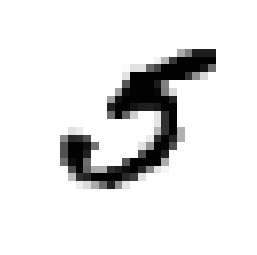

In [382]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,interpolation='nearest')
plt.axis('off')
y[36000]

In [348]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    print('shape',instances.shape)
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1)) # 利用np.concatenate把10个图片压成一行
    image = np.concatenate(row_images, axis=0) # 利用np.concatenate把10个组合图片压成一张 280*280
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off") 

In [466]:
(example_images.shape)

(100, 784)

shape (100, 784)


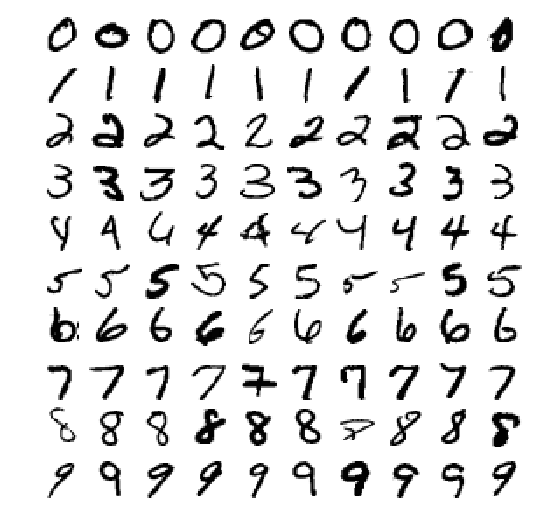

In [355]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [455]:
len(row_iamges)

10

In [370]:
# 我们把MNIST数据集划分成两个部分，前60000个为训练集合，后10000个为测试集合
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, X_test = X_train[shuffle_index], y_train[shuffle_index]

In [375]:
# 下面我们使用一个二元分类器，来测试我们的分类性能,二元分类器只能区分两种情况，因此需要改造一下标签
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


In [410]:
# Okay 我们使用Stochastic Grandient Descent SGD 分类器，使用Scikit-Learn SGDClassifier 类
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
# 现在分类器已经训练好了，下面我们检测一下
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False)

In [411]:
sgd_clf.predict([some_digit])

array([False])

In [412]:
some_digit.sum()

27737

## 3.3 分类的评估
针对分类器的评估比回归器复杂一些，需要更多技巧。本节我们将详细介绍分类器的评估。
### 3.3.1 交叉验证的精度测量
使用交叉验证是一个不错的方法。为了解释交叉验证原理，我们首先写一个手动的程序。

In [386]:
## 交叉验证代码
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sgd_clf = SGDClassifier(random_state=42)
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # print(train_index[:10], test_index[:10])
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])    
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.75885
0.8557
0.87915


sklearn提供了一个简单的函数cross_val_score 函数，能使用K-fold交叉验证评估分类器性能
如下示例

In [387]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.75885, 0.8557 , 0.87915])

✌️ 好像精度还不错，真的是分类器很不错嘛，下面我们做个小时按

In [388]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([1.     , 0.72895, 1.     ])

这个结果有点出乎意料之外，因为图片中只有10%的是数字5，
### 3.3.2 混淆矩阵
另一个比较好的方法评估分类器性能的是混淆矩阵(confusion matrix)，为了计算混淆矩阵，我们可以使用cross_val_predict,这个函数执行K-折交叉验证，但是返回值不是评估准确率，返回每次预测的结果，

In [401]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [403]:
confusion_matrix(y_train_pred, y_train_5)

array([[49369,  4916],
       [ 5210,   505]])

对于二分问题，可以将样例根据真实类别与学习器预测类别的组合划分为真正例(true positive),假正率(false positive),真反率(true negative),假反率(false negative)四种情况，令TP,FP, TN, FN分别表示对应的样例，显然有TP+FP+TN+FN=样例总数。
$$精确度 查准率 P= \frac{TP}{TP+FP}$$
$$召回率 查全率 R= \frac{TP}{TP+FN}$$

精度和召回率的计算:

In [404]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_pred, y_train_5))
print(recall_score(y_train_pred, y_train_5))

0.09315624423538092
0.08836395450568679


In [406]:
505/(505+4916), 505/(505+5210)

(0.09315624423538092, 0.08836395450568679)

In [408]:
from sklearn.metrics import f1_score
f1_score(y_train_pred, y_train_5)

0.09069683908045977

In [415]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-204211.42640902])

In [416]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [417]:
y_some_digit_pred

array([False])

In [421]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [425]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

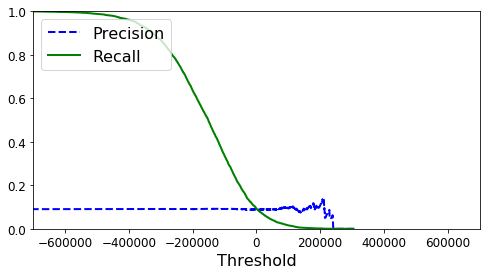

In [427]:
# Where to save the figures
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [428]:
(y_train_pred == (y_scores > 0)).all()

True

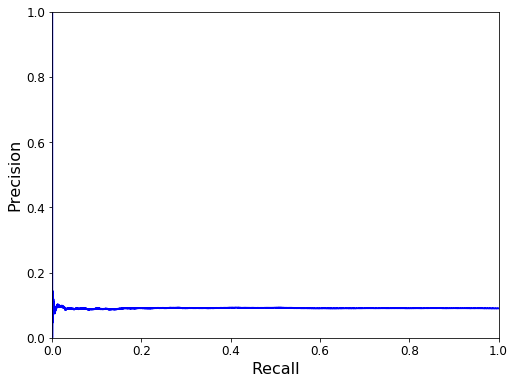

In [430]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

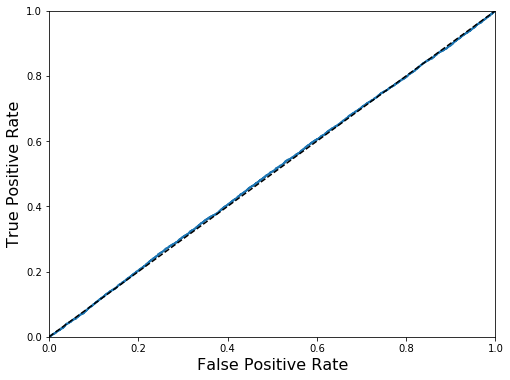

In [304]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [305]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

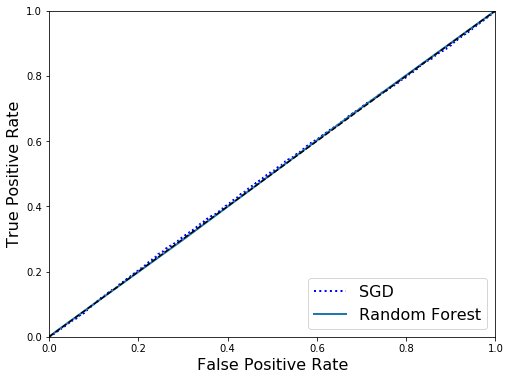

In [306]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [431]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [435]:
y_probas_forest.sum()

60000.0

In [432]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

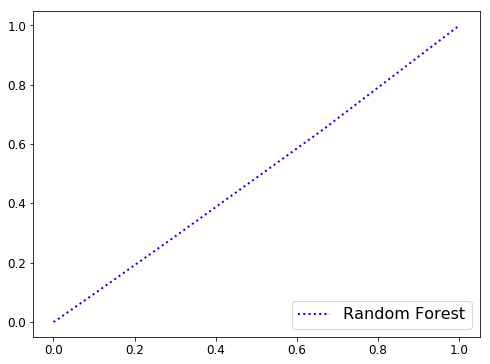

In [433]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest, "b:", linewidth=2, label="Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [74]:
def split_train_test(data, test_ratio):
    """data is pandas.DataFrame"""
    np.random.seed(42) # 决定是否采用相同起点
    shuffled_indics = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indics[:test_set_size]
    train_indices = shuffled_indics[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

还有一种方法，根据索引进行分类，决定是测试集还是训练集。通过计算

In [61]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [62]:
train_set.sample(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18807,18807,-121.64,40.90,24.0,2237.0,434.0,834.0,318.0,1.7538,90300.0,INLAND
318,318,-122.19,37.76,38.0,1493.0,370.0,1144.0,351.0,0.7683,81800.0,NEAR BAY
16715,16715,-120.68,35.50,19.0,3369.0,673.0,1834.0,646.0,3.7672,173800.0,<1H OCEAN
3465,3465,-118.46,34.31,24.0,2920.0,601.0,1460.0,598.0,4.2708,218200.0,<1H OCEAN
10935,10935,-117.90,33.74,25.0,808.0,163.0,1066.0,189.0,4.7679,173100.0,<1H OCEAN
17496,17496,-119.80,34.43,27.0,3143.0,537.0,1760.0,570.0,4.6957,271500.0,NEAR OCEAN
14214,14214,-117.06,32.68,41.0,2665.0,515.0,1664.0,512.0,2.3750,113500.0,NEAR OCEAN
314,314,-122.19,37.76,41.0,921.0,207.0,522.0,159.0,1.2083,72500.0,NEAR BAY
11799,11799,-121.27,38.87,16.0,2094.0,358.0,1092.0,357.0,4.4769,191400.0,INLAND
20534,20534,-121.74,38.56,18.0,3960.0,1151.0,2248.0,1144.0,1.7257,179100.0,INLAND


In [63]:
hashlib.md5(housing_with_id['index'][1]).digest()[-1]

203

一般来说需要索引是独一无二的，本例数据集中没有这样的索引，其实也可以构造一个


In [64]:
housing_with_id['id'] = housing['longitude']*1000 + housing['latitude'] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [69]:
train_set.sample(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
1461,1461,-121.99,37.97,30.0,3320.0,589.0,1470.0,543.0,4.6071,184100.0,INLAND,-121952.03
1972,1972,-120.54,38.75,9.0,3006.0,540.0,1102.0,418.0,3.9812,136600.0,INLAND,-120501.25
6948,6948,-118.08,33.99,36.0,2024.0,590.0,2028.0,573.0,2.8152,163900.0,<1H OCEAN,-118046.01
14743,14743,-117.06,32.58,11.0,2879.0,679.0,2098.0,673.0,3.5125,142400.0,NEAR OCEAN,-117027.42
12485,12485,-121.48,38.58,42.0,1823.0,566.0,761.0,503.0,1.2450,137500.0,INLAND,-121441.42
14128,14128,-117.09,32.75,28.0,1220.0,391.0,1286.0,396.0,1.2286,105000.0,NEAR OCEAN,-117057.25
8300,8300,-118.14,33.76,50.0,914.0,167.0,322.0,165.0,4.7361,418800.0,NEAR OCEAN,-118106.24
5274,5274,-118.53,34.03,40.0,4350.0,763.0,1551.0,665.0,7.0318,500001.0,<1H OCEAN,-118495.97
17672,17672,-121.87,37.30,14.0,360.0,124.0,134.0,84.0,2.7411,112500.0,<1H OCEAN,-121832.70
12540,12540,-121.50,38.55,52.0,2784.0,455.0,957.0,448.0,5.6402,209800.0,INLAND,-121461.45


scikit-learn 提供了将数据集进行分割的方法，其中最简单一个是train_test_split

In [70]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [71]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


### 3.1.2 分层抽样
分层抽样法也叫类型抽样法。它是从一个可以分成不同子总体（或称为层）的总体中，按规定的比例从不同层中随机抽取样品（个体）的方法。这种方法的优点是，样本的代表性比较好，抽样误差比较小。缺点是抽样手续较简单随机抽样还要繁杂些。定量调查中的分层抽样是一种卓越的概率抽样方式，在调查中经常被使用。
当目前为止，我们使用单纯抽样的留出法，如果样本数据足够大，则表现良好。因此当样本小的时候就会存在显著的采样偏差。
假设有人对你说平均收入对于预测平均房价是很重要的，你可以按收入进行分层，并按照比例从不同收入中随机抽取样本。记抽样后不改变主要性质。


In [83]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [84]:
housing.income_cat.describe()

count    20640.000000
mean         3.006686
std          1.054618
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: income_cat, dtype: float64

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [94]:
list(split.split(housing, housing['income_cat']))

[(array([17606, 18632, 14650, ..., 13908, 11159, 15775]),
  array([ 5241, 10970, 20351, ...,  4019, 12107,  2398]))]

# Multiclass classification

In [436]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3.])

In [438]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-210452.87357952, -179078.98124098, -158861.99055847,
          55445.96053057, -109431.4224187 , -204211.42640902,
         -23101.19976253, -155157.91383253, -131219.0357276 ,
         -97802.06089922]])

In [439]:
some_digit_scores.argmax()

3

In [440]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [441]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3.])

In [442]:
len(ovo_clf.estimators_)

45

In [443]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([2.])

In [444]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.4, 0.1, 0.1, 0. , 0.1, 0.1, 0.1, 0.1]])

In [445]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.10212957, 0.09955498, 0.10011502])

In [446]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.10052989, 0.10010501, 0.09961494])

In [447]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[837, 462, 512, 726, 632, 546, 574, 517, 570, 547],
       [930, 532, 576, 779, 784, 664, 640, 563, 666, 608],
       [804, 500, 505, 716, 663, 597, 571, 493, 566, 543],
       [881, 455, 559, 718, 709, 537, 609, 527, 578, 558],
       [817, 482, 513, 672, 667, 538, 554, 476, 588, 535],
       [755, 433, 483, 616, 597, 533, 567, 437, 534, 466],
       [793, 489, 510, 728, 672, 565, 517, 528, 565, 551],
       [819, 502, 509, 732, 764, 607, 604, 523, 597, 608],
       [776, 455, 468, 687, 679, 577, 616, 467, 592, 534],
       [824, 466, 510, 657, 708, 540, 598, 489, 576, 581]])

In [448]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

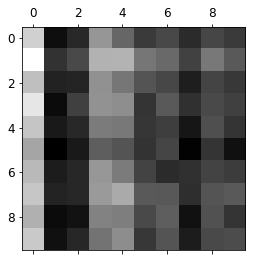

In [450]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [467]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=4, weights=uniform ..................................
[CV] n_neighbors=4, weights=uniform ..................................


KeyboardInterrupt: 